# Sentiment Analysis for Predicting Stock Market Movements using News Headlines

### Library Import

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
#Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()

In [3]:
#Sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

### Data import

In [4]:
news_data  = pd.read_csv('dataset/RedditNews.csv', encoding = "ISO-8859-1", parse_dates=["Date"])
stock_data = pd.read_csv('dataset/upload_DJIA_table.csv', encoding = "ISO-8859-1", parse_dates=["Date"])  
combined_data = pd.read_csv('dataset/Combined_News_DJIA.csv', encoding = "ISO-8859-1",parse_dates=["Date"])  
pre_process_data = pd.read_csv('dataset/pre_process_all_news_days.csv', encoding = "ISO-8859-1",parse_dates=["Date"])  

In [5]:
news_data.head()

Date                                               News
0 2016-07-01  A 117-year-old woman in Mexico City finally re...
1 2016-07-01   IMF chief backs Athens as permanent Olympic host
2 2016-07-01  The president of France says if Brexit won, so...
3 2016-07-01  British Man Who Must Give Police 24 Hours' Not...
4 2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...

In [6]:
news_data.describe()

Date                                               News
count                 73608                                              73608
unique                 2943                                              73537
top     2008-10-26 00:00:00  Iceland Declares Independence from Internation...
freq                     50                                                  3
first   2008-06-08 00:00:00                                                NaN
last    2016-07-01 00:00:00                                                NaN

In [7]:
stock_data.describe()

Open          High           Low         Close     Adj Close  \
count   2007.000000   2007.000000   2007.000000   2007.000000   2007.000000   
mean   13440.521673  13522.983777  13354.193266  13444.615090  13444.615090   
std     3135.303099   3128.138600   3142.486057   3135.899534   3135.899534   
min     6547.009766   6709.609863   6469.950195   6547.049805   6547.049805   
25%    10932.120117  11035.544922  10833.385254  10933.510254  10933.510254   
50%    12981.129883  13055.750000  12926.490234  12985.110352  12985.110352   
75%    16463.910156  16531.419922  16378.909668  16462.030273  16462.030273   
max    18315.060547  18351.359375  18272.560547  18312.390625  18312.390625   

             Volume  Next_1_Adj_Close  Next_2_Adj_Close  Next_3_Adj_Close  \
count  2.007000e+03       2006.000000       2005.000000       2004.000000   
mean   1.635300e+08      13442.369450      13440.131235      13438.008207   
std    9.396910e+07       3135.066891       3134.245466       3133.585404   
min    8.410000e+06       6547.049805       6547.049805       6547.049805   
25%    1.002250e+08      10930.290283      10927.070312      10927.070312   
50%    1.362700e+08      12984.900391      12984.690430      12983.820312   
75%    1.943600e+08      16460.927734      16459.750000      16458.857910   
max    6.749200e+08      18312.390625      18312.390625      18312.390625   

       Next_4_Adj_Close  Next_5_Adj_Close   Label_1day   Label_2day  \
count       2003.000000       2002.000000  2007.000000  2007.000000   
mean       13436.025325      13434.175068     0.463378     0.438964   
std         3133.110109       3132.798125     0.498781     0.496384   
min         6547.049805       6547.049805     0.000000     0.000000   
25%        10927.070312      10927.070312     0.000000     0.000000   
50%        12982.950195      12982.229980     0.000000     0.000000   
75%        16458.110352      16456.702637     1.000000     1.000000   
max        18312.390625      18312.390625     1.000000     1.000000   

        Label_3day   Label_4day   Label_5day  
count  2007.000000  2007.000000  2007.000000  
mean      0.427504     0.429995     0.424016  
std       0.494840     0.495198     0.494316  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000

In [8]:
stock_data.head(3)

Date          Open          High           Low         Close  \
0 2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   
1 2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234   
2 2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688   

      Adj Close     Volume  Next_1_Adj_Close  Next_2_Adj_Close  \
0  17949.369141   82160000      17929.990234      17694.679688   
1  17929.990234  133030000      17694.679688      17409.720703   
2  17694.679688  106380000      17409.720703      17140.240234   

   Next_3_Adj_Close  Next_4_Adj_Close  Next_5_Adj_Close  Label_1day  \
0      17409.720703      17140.240234      17400.750000           0   
1      17140.240234      17400.750000      18011.070312           0   
2      17400.750000      18011.070312      17780.830078           0   

   Label_2day  Label_3day  Label_4day  Label_5day  
0           0           0           0           0  
1           0           0           0           1  
2           0           0           1           1

In [9]:
combined_data.head(2)

Date  Label                                               Top1  \
0 2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-08-11      1  b'Why wont America and Nato help us? If they w...   

                                          Top2  \
0      b'BREAKING: Musharraf to be impeached.'   
1  b'Bush puts foot down on Georgian conflict'   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   

                                                Top4  \
0  b'Russian tanks are moving towards the capital...   
1  b'Georgian army flees in disarray as Russians ...   

                                                Top5  \
0  b"Afghan children raped with 'impunity,' U.N. ...   
1      b"Olympic opening ceremony fireworks 'faked'"   

                                                Top6  \
0  b'150 Russian tanks have entered South Ossetia...   
1  b'What were the Mossad with fraudulent New Zea...   

                                                Top7  \
0  b"Breaking: Georgia invades South Ossetia, Rus...   
1  b'Russia angered by Israeli military sale to G...   

                                                Top8  ...  \
0  b"The 'enemy combatent' trials are nothing but...  ...   
1  b'An American citizen living in S.Ossetia blam...  ...   

                                               Top16  \
0  b'Georgia Invades South Ossetia - if Russia ge...   
1  b'Israel and the US behind the Georgian aggres...   

                                               Top17  \
0                b'Al-Qaeda Faces Islamist Backlash'   
1  b'"Do not believe TV, neither Russian nor Geor...   

                                               Top18  \
0  b'Condoleezza Rice: "The US would not act to p...   
1  b'Riots are still going on in Montreal (Canada...   

                                               Top19  \
0  b'This is a busy day:  The European Union has ...   
1    b'China to overtake US as largest manufacturer'   

                                               Top20  \
0  b"Georgia will withdraw 1,000 soldiers from Ir...   
1                     b'War in South Ossetia [PICS]'   

                                               Top21  \
0  b'Why the Pentagon Thinks Attacking Iran is a ...   
1  b'Israeli Physicians Group Condemns State Tort...   

                                               Top22  \
0  b'Caucasus in crisis: Georgia invades South Os...   
1  b' Russia has just beaten the United States ov...   

                                               Top23  \
0  b'Indian shoe manufactory  - And again in a se...   
1  b'Perhaps *the* question about the Georgia - R...   

                                               Top24  \
0  b'Visitors Suffering from Mental Illnesses Ban...   
1                 b'Russia is so much better at war'   

                                               Top25  
0           b"No Help for Mexico's Kidnapping Surge"  
1  b"So this is what it's come to: trading sex fo...  

[2 rows x 27 columns]

In [10]:
combined_data.describe()

Label
count  1989.000000
mean      0.535445
std       0.498867
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

In [11]:
stock_data.isna().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Next_1_Adj_Close    1
Next_2_Adj_Close    2
Next_3_Adj_Close    3
Next_4_Adj_Close    4
Next_5_Adj_Close    5
Label_1day          0
Label_2day          0
Label_3day          0
Label_4day          0
Label_5day          0
dtype: int64

In [12]:
news_data.isna().sum()

Date    0
News    0
dtype: int64

In [13]:
combined_data.isna().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [14]:
#Get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

In [15]:
print("Origial headline:", pre_process_data['news'][1])

Origial headline: ["b'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?'"
 "b'Bush puts foot down on Georgian conflict'"
 'b"Jewish Georgian minister: Thanks to Israeli training, we\'re fending off Russia "'
 "b'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired'"
 'b"Olympic opening ceremony fireworks \'faked\'"'
 "b'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?'"
 "b'Russia angered by Israeli military sale to Georgia'"
 "b'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people'"
 "b'Welcome To World War IV! Now In High Definition!'"
 'b"Georgia\'s move, a mistake of monumental proportions "'
 "b'Russia presses deeper into Georgia; U.S. says regime change is goal'"
 "b'Abhinav Bindra wins first ever Individual Olympic Gold Medal for India'"
 "b' U.S. ship heads for Arctic to define territory'"
 "b'Drivers in a Jerus

In [16]:
print("Clean headline:",pre_process_data['clean_news'][1])

Clean headline: why will not usa and nato help us if they will not help us now why did we help them in iraq bush puts foot down on georgian conflict jewish georgian minister thanks to israeli training were fending off russia georgian army flees in disarray as russians advance gori abandoned to russia without a shot fired olympic opening ceremony fireworks faked what were the mossad with fraudulent new zealand passports doing in iraq russia angered by israeli military sale to georgia an usan citizen living in sossetia blames usa and georgian leaders for the genocide of innocent people welcome to world war iv now in high definition georgias move a mistake of monumental proportions russia presses deeper into georgia usa says regime change is goal abhinav bindra wins first ever individual olympic gold medal for india usa ship heads for arctic to define territory drivers in a jerusalem taxi station threaten to quit rather than work for their new boss an ara the french team is stunned by phe

### Sentiment score extraction

In [17]:
sentiment_data = pd.read_csv('dataset/news_sentiment_analysis.csv',encoding = "ISO-8859-1",parse_dates=["Date"])  

In [18]:
sentiment_data.head(3)

Date                                         clean_news  \
0 2008-08-08  georgia downs two russian warplanes as countri...   
1 2008-08-11  why will not usa and nato help us if they will...   
2 2008-08-12  remember that adorable yearold who sang at the...   

                                        news_stemmed  Label  Label_1day  \
0  ['georgia', 'down', 'two', 'russian', 'warplan...      0           0   
1  ['usa', 'nato', 'help', 'us', 'help', 'us', 'h...      1           0   
2  ['rememb', 'ador', 'yearold', 'sang', 'open', ...      0           1   

   Label_2day  Label_3day  Label_4day  Label_5day  Compound_NTUSD  ...  \
0           0           0           0           0          0.9639  ...   
1           0           0           0           0          0.0885  ...   
2           1           0           1           0          0.8511  ...   

   Compound_NTUSD_neu  Compound_NTUSD_neg  Sentiment_NTUSD Textblob_polarity  \
0               0.414               0.259         Positive         -0.050303   
1               0.421               0.266         Positive          0.115398   
2               0.522               0.208         Positive         -0.044302   

   Textblob_subjectivity  Sentiment_Textblob FinBert_pos  FinBert_neg  \
0               0.277104            Negative    0.024655     0.615020   
1               0.395629            Positive    0.029502     0.447413   
2               0.536234            Negative    0.033390     0.234335   

   FinBert_neu  Sentiment_FinBert  
0     0.360324           Negative  
1     0.523085            Neutral  
2     0.732276            Neutral  

[3 rows x 21 columns]

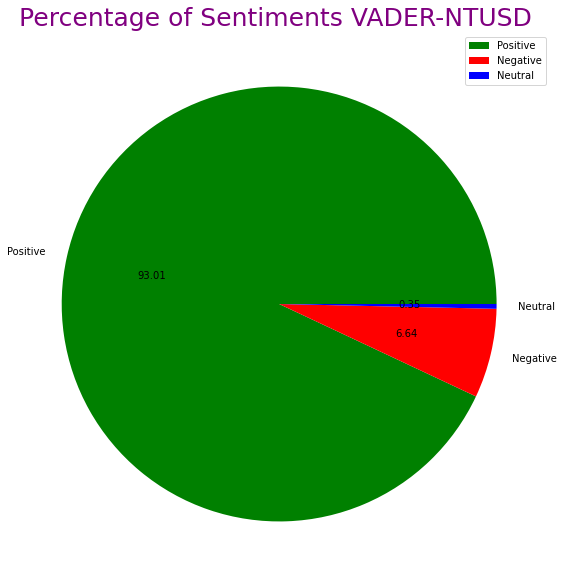

In [22]:
# The distribution of sentiments
plt.figure(figsize=(10,10))
NTUSD_counts =sentiment_data.Sentiment_NTUSD.value_counts()
labels=NTUSD_counts.index
plt.pie(NTUSD_counts,labels=labels,autopct='%.2f',colors = ['green','red','blue'])
plt.title("Percentage of Sentiments VADER-NTUSD ",fontsize=25,color='purple')
plt.legend()
plt.show()

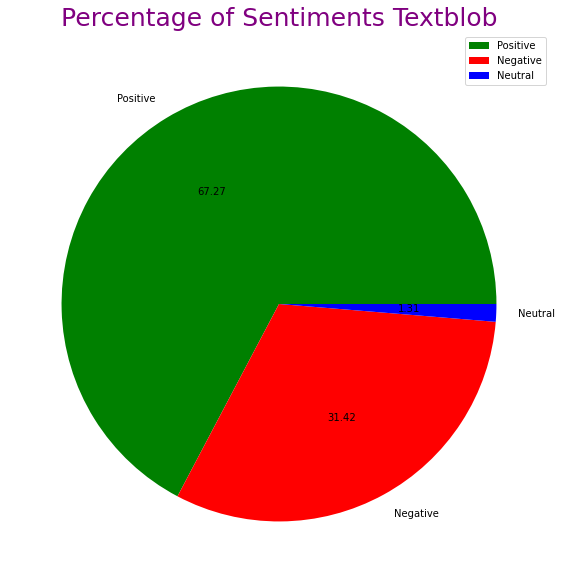

In [24]:
# The distribution of sentiments
plt.figure(figsize=(10,10))
Textblob_counts =sentiment_data.Sentiment_Textblob.value_counts()
labels=Textblob_counts.index
plt.pie(Textblob_counts,labels=labels,autopct='%.2f',colors = ['green','red','blue'])
plt.title("Percentage of Sentiments Textblob",fontsize=25,color='purple')
plt.legend()
plt.show()

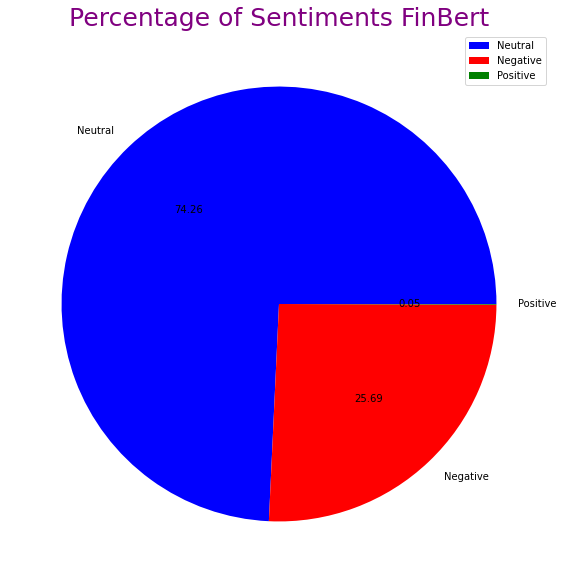

In [25]:
plt.figure(figsize=(10,10))
FinBert_counts =sentiment_data.Sentiment_FinBert.value_counts()
labels=FinBert_counts.index
plt.pie(FinBert_counts,labels=labels,autopct='%.2f',colors = ['blue','red','green'])
plt.title("Percentage of Sentiments FinBert",fontsize=25,color='purple')
plt.legend()
plt.show()

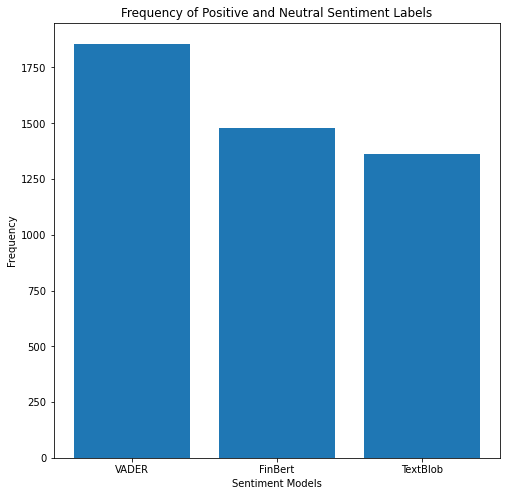

In [27]:
# create a bar plot
plt.figure(figsize=(8,8))
sentiments = ['VADER', 'FinBert', 'TextBlob']
counts = [NTUSD_counts[0]+NTUSD_counts[2], FinBert_counts[0]+FinBert_counts[2], Textblob_counts[0]+Textblob_counts[2] ]

plt.bar(sentiments, counts)

# label the plot
plt.title('Frequency of Positive and Neutral Sentiment Labels')
plt.xlabel('Sentiment Models')
plt.ylabel('Frequency')

# display the plot
plt.show()

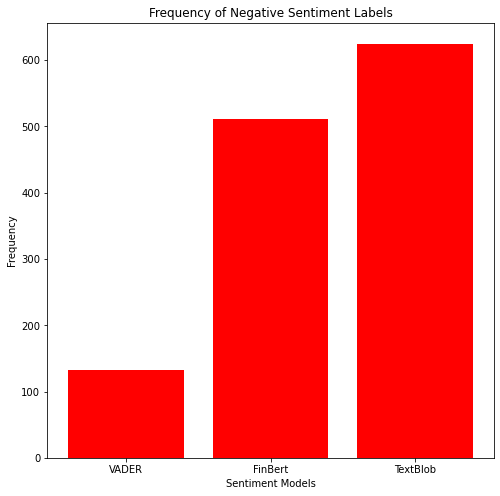

In [28]:
# create a bar plot
plt.figure(figsize=(8,8))
counts = [NTUSD_counts[1], FinBert_counts[1], Textblob_counts[1] ]

plt.bar(sentiments, counts,color='red')

# label the plot
plt.title('Frequency of Negative Sentiment Labels')
plt.xlabel('Sentiment Models')
plt.ylabel('Frequency')

# display the plot
plt.show()

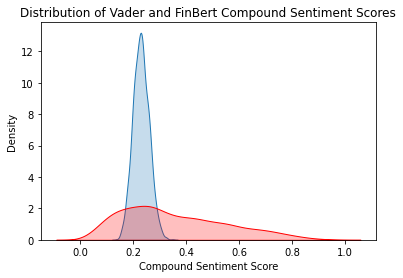

In [29]:
# Select the compound sentiment scores from Vader and FinBert
vader_compound = sentiment_data.Compound_NTUSD_neg
finbert_compound = sentiment_data.FinBert_neg

# Create a KDE plot of the compound sentiment scores
sns.kdeplot(vader_compound, shade=True, label='Vader')
sns.kdeplot(finbert_compound, shade=True, label='FinBert',color='red')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Vader and FinBert Compound Sentiment Scores')
plt.show()

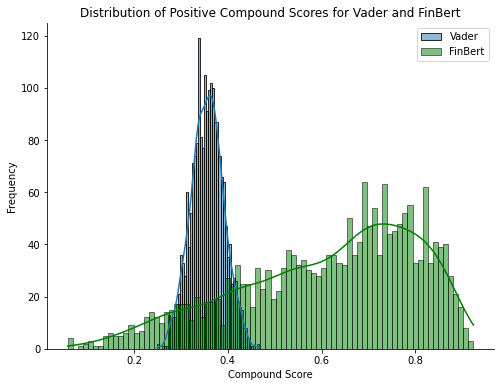

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(sentiment_data.Compound_NTUSD_pos, ax=ax, kde=True, bins=50, label='Vader')
sns.histplot(sentiment_data.FinBert_neu, ax=ax, kde=True, bins=80, label='FinBert', color='green')

ax.set_xlabel('Compound Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Positive Compound Scores for Vader and FinBert')
sns.despine()
plt.legend()
plt.show()

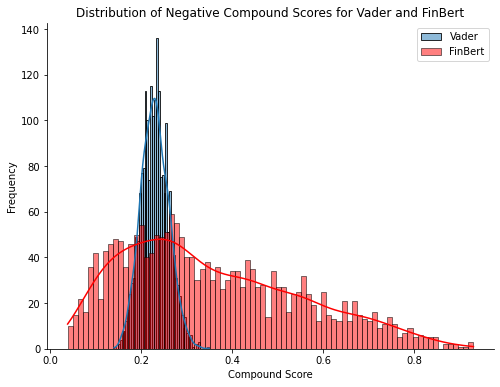

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(sentiment_data.Compound_NTUSD_neg, ax=ax, kde=True, bins=50, label='Vader')
sns.histplot(sentiment_data.FinBert_neg, ax=ax, kde=True, bins=80, label='FinBert', color='red')

ax.set_xlabel('Compound Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Negative Compound Scores for Vader and FinBert')
sns.despine()
plt.legend()
plt.show()

Text(0.5, 1.0, 'Vader Positive Compound')

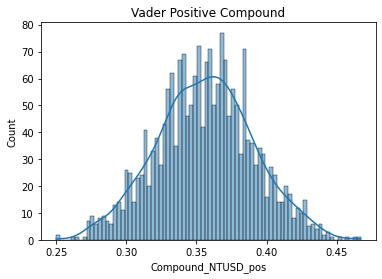

In [32]:
ax = sns.histplot(data=sentiment_data, x="Compound_NTUSD_pos",bins=80,kde=True)
plt.title("Vader Positive Compound")

Text(0.5, 1.0, 'FinBert Negative Compound')

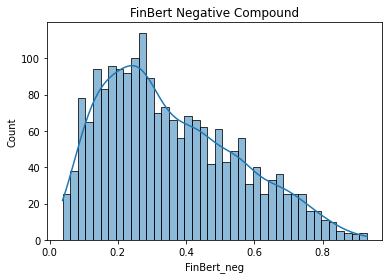

In [33]:
ax = sns.histplot(data=sentiment_data, x="FinBert_neg",bins=40,kde=True)
plt.title("FinBert Negative Compound")

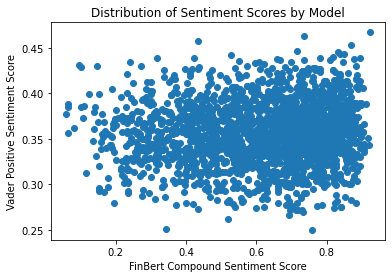

In [34]:
# Create a scatter plot using Matplotlib
plt.scatter(sentiment_data['FinBert_neu'], sentiment_data['Compound_NTUSD_pos'])
plt.xlabel('FinBert Compound Sentiment Score')
plt.ylabel('Vader Positive Sentiment Score')
plt.title('Distribution of Sentiment Scores by Model')
plt.show()

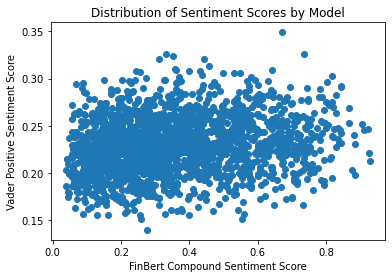

In [35]:
# Create a scatter plot using Matplotlib
plt.scatter(sentiment_data['FinBert_neg'], sentiment_data['Compound_NTUSD_neg'])
plt.xlabel('FinBert Compound Sentiment Score')
plt.ylabel('Vader Positive Sentiment Score')
plt.title('Distribution of Sentiment Scores by Model')
plt.show()

### Exploratory Data Analysis

In [36]:
#calculate the difference between opening and closing stock value
stock_data['Diff'] = stock_data.Close - stock_data.Open

In [37]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=stock_data.Date, y=stock_data.Diff,
                    mode='lines'))
title = []
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Aug, 2008 - Jun, 2016',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig1.update_layout(xaxis_title='Date',
                   yaxis_title='Difference between opening and closing',
                  annotations=title)
fig1.show()

In [38]:
stock_data['PercentChange']=stock_data['Adj Close'].pct_change()
hist_fig = px.histogram(x=stock_data['PercentChange'], nbins=150, title='Histogram of Percent Change',
                   labels={'x':'Percent Change'})
hist_fig.show()

Label
0     924
1    1065
Name: Date, dtype: int64


<AxesSubplot:xlabel='Label', ylabel='count'>

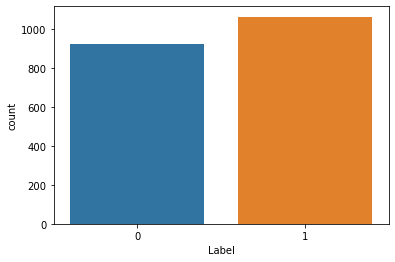

In [39]:
print(combined_data.groupby(['Label']).count()['Date'])
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=combined_data)

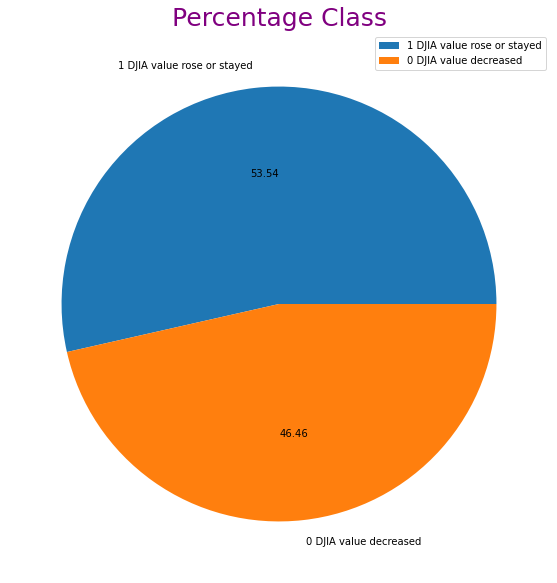

In [40]:
plt.figure(figsize=(10,10))
ax =combined_data.Label.value_counts()
labels=['1 DJIA value rose or stayed','0 DJIA value decreased']
plt.pie(ax,labels=labels,autopct='%.2f')
plt.title("Percentage Class",fontsize=25,color='purple')
plt.legend()
plt.show()

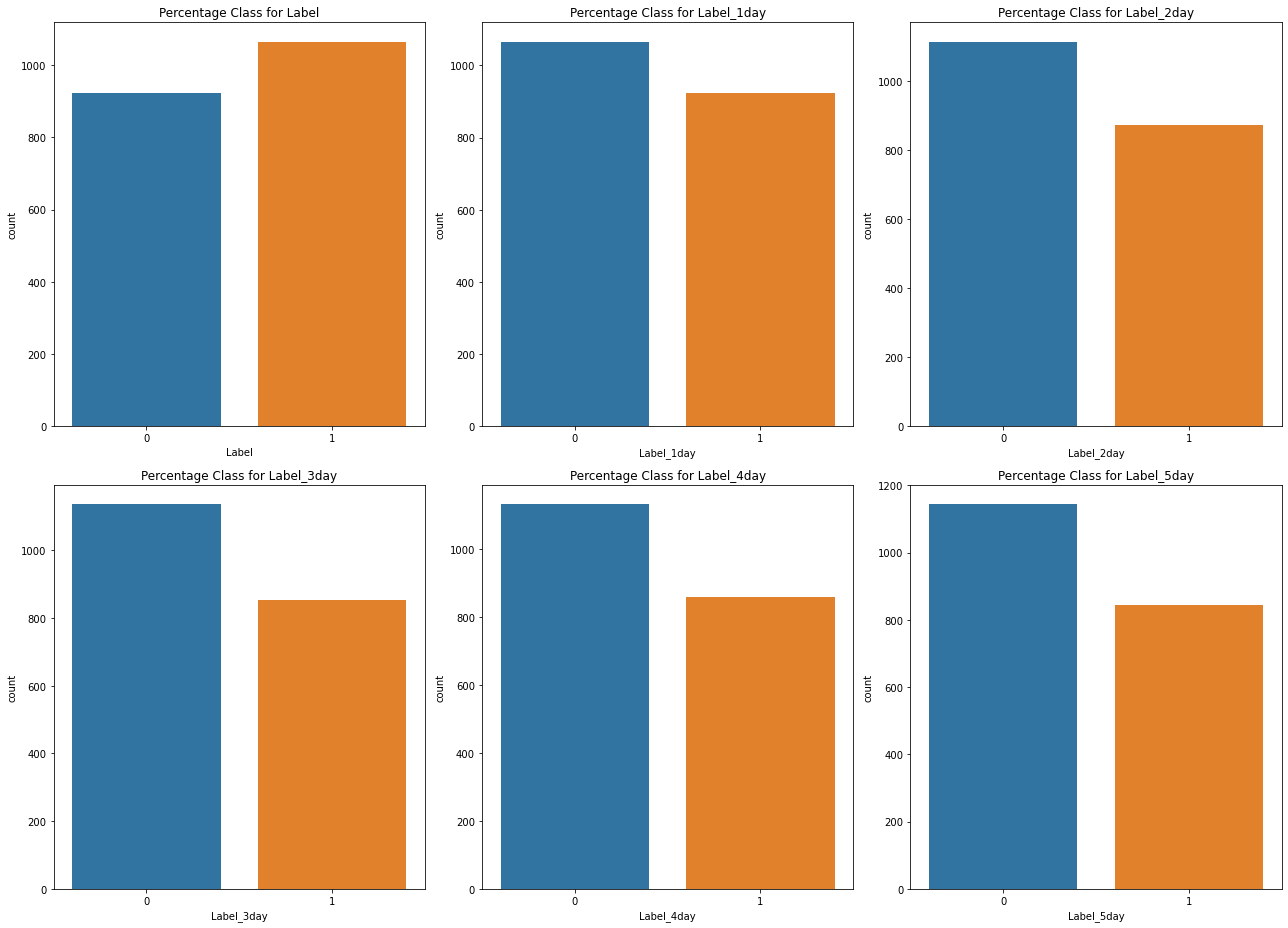

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,13))
for i, label in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    row = i // 3
    col = i % 3
    # Plot the countplot for the current label on the current subplot
    sns.countplot(x=label, data=sentiment_data, ax=ax[row, col])
    
    # Set the title of the subplot
    ax[row, col].set_title(f"Percentage Class for {label}")
    
# Adjust the layout and spacing of the subplots
fig.tight_layout()

In [42]:
sentiment_data['nr_of_char'] = sentiment_data['clean_news'].str.len()
sentiment_data['nr_of_char'] = sentiment_data['nr_of_char'] / sentiment_data['nr_of_char'].max()
sentiment_data[['Sentiment_FinBert', 'nr_of_char']].pivot(columns = 'Sentiment_FinBert', values = 'nr_of_char').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of char counts')

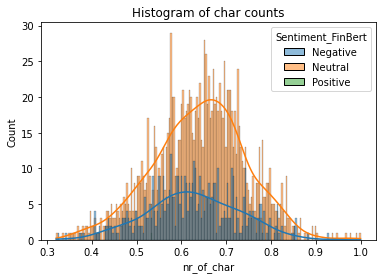

In [43]:
ax = sns.histplot(data=sentiment_data, x="nr_of_char",bins=200, hue="Sentiment_FinBert",kde=True)
plt.title("Histogram of char counts")

In [44]:
sentiment_data[['Sentiment_NTUSD', 'nr_of_char']].pivot(columns = 'Sentiment_NTUSD', values = 'nr_of_char').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of char counts')

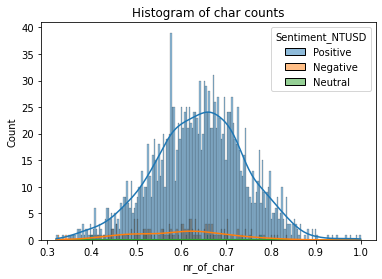

In [45]:
ax = sns.histplot(data=sentiment_data, x="nr_of_char",bins=200, hue="Sentiment_NTUSD",kde=True)
plt.title("Histogram of char counts")

In [46]:
sentiment_data[['Sentiment_Textblob', 'nr_of_char']].pivot(columns = 'Sentiment_Textblob', values = 'nr_of_char').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of char counts')

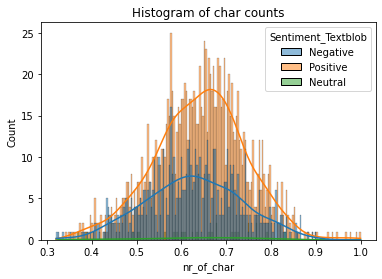

In [47]:
ax = sns.histplot(data=sentiment_data, x="nr_of_char",bins=200, hue="Sentiment_Textblob",kde=True)
plt.title("Histogram of char counts")

In [48]:
sentiment_data['nr_of_words'] = sentiment_data['clean_news'].str.split().str.len()
sentiment_data['nr_of_words'] = sentiment_data['nr_of_words'] / sentiment_data['nr_of_words'].max()
sentiment_data[['Sentiment_FinBert', 'nr_of_words']].pivot(columns = 'Sentiment_FinBert', values = 'nr_of_words').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of word counts')

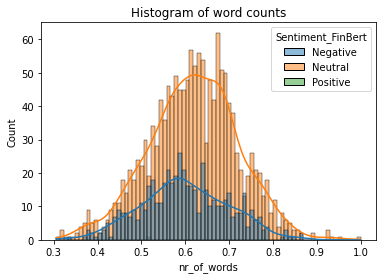

In [49]:
ax = sns.histplot(data=sentiment_data, x="nr_of_words",bins=80, hue="Sentiment_FinBert",kde=True)
plt.title("Histogram of word counts")

In [50]:
sentiment_data[['Sentiment_Textblob', 'nr_of_words']].pivot(columns = 'Sentiment_Textblob', values = 'nr_of_words').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of word counts')

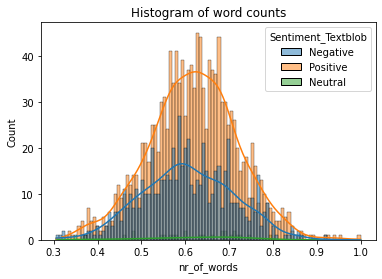

In [51]:
ax = sns.histplot(data=sentiment_data, x="nr_of_words",bins=100, hue="Sentiment_Textblob",kde=True)
plt.title("Histogram of word counts")

In [52]:
sentiment_data[['Sentiment_NTUSD', 'nr_of_words']].pivot(columns = 'Sentiment_NTUSD', values = 'nr_of_words').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of word counts')

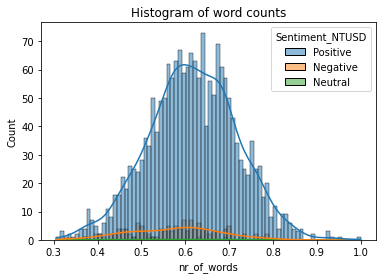

In [53]:
ax = sns.histplot(data=sentiment_data, x="nr_of_words",bins=80, hue="Sentiment_NTUSD",kde=True)
plt.title("Histogram of word counts")

In [54]:
sentiment_data['nr_of_unique_words'] = sentiment_data['clean_news'].apply(lambda x: len(set(x.split())))
sentiment_data['nr_of_unique_words'] = sentiment_data['nr_of_unique_words'] / sentiment_data['nr_of_unique_words'].max()
sentiment_data[['Sentiment_NTUSD', 'nr_of_unique_words']].pivot(columns = 'Sentiment_NTUSD', values = 'nr_of_unique_words').iplot(kind='box')

Text(0.5, 1.0, 'Histogram of unique words counts')

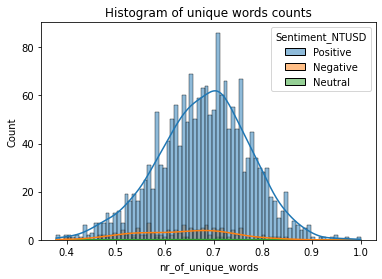

In [55]:
ax = sns.histplot(data=sentiment_data, x="nr_of_unique_words",bins=80, hue="Sentiment_NTUSD",kde=True)
plt.title("Histogram of unique words counts")

In [56]:
sentiment_data[['Sentiment_Textblob', 'nr_of_unique_words']].pivot(columns = 'Sentiment_Textblob', values = 'nr_of_unique_words').iplot(kind='box')

Text(0.5, 1.0, 'Histogram of unique words counts')

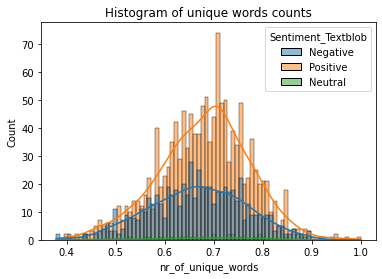

In [57]:
ax = sns.histplot(data=sentiment_data, x="nr_of_unique_words",bins=80, hue="Sentiment_Textblob",kde=True)
plt.title("Histogram of unique words counts")

In [58]:
sentiment_data[['Sentiment_FinBert', 'nr_of_unique_words']].pivot(columns = 'Sentiment_FinBert', values = 'nr_of_unique_words').iplot(kind='box')

Text(0.5, 1.0, 'Histogram of unique words counts')

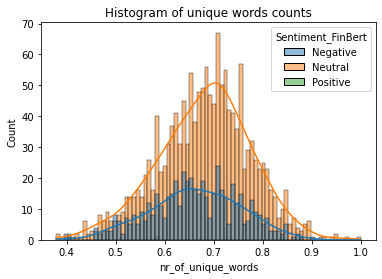

In [59]:
ax = sns.histplot(data=sentiment_data, x="nr_of_unique_words",bins=80, hue="Sentiment_FinBert",kde=True)
plt.title("Histogram of unique words counts")

In [60]:
stop_words = set(stopwords.words('english'))
sentiment_data['nr_of_stopwords'] = sentiment_data['clean_news'].str.split().apply(lambda x: len(set(x) & stop_words))
sentiment_data['nr_of_stopwords'] = sentiment_data['nr_of_stopwords'] / sentiment_data['nr_of_stopwords'].max()
sentiment_data[['Sentiment_NTUSD', 'nr_of_stopwords']].pivot(columns = 'Sentiment_NTUSD', values = 'nr_of_stopwords').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of stopwords counts')

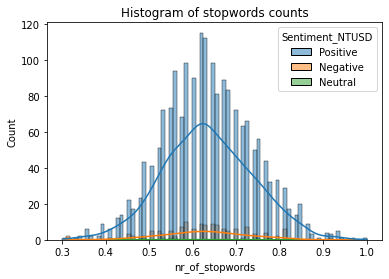

In [61]:
ax = sns.histplot(data=sentiment_data, x="nr_of_stopwords",bins=80, hue="Sentiment_NTUSD",kde=True)
plt.title("Histogram of stopwords counts")

In [62]:
sentiment_data[['Sentiment_Textblob', 'nr_of_stopwords']].pivot(columns = 'Sentiment_Textblob', values = 'nr_of_stopwords').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of stopwords counts')

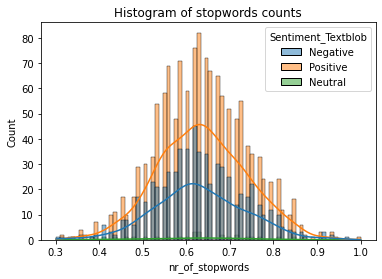

In [63]:
ax = sns.histplot(data=sentiment_data, x="nr_of_stopwords",bins=80, hue="Sentiment_Textblob",kde=True)
plt.title("Histogram of stopwords counts")

In [64]:
sentiment_data[['Sentiment_FinBert', 'nr_of_stopwords']].pivot(columns = 'Sentiment_FinBert', values = 'nr_of_stopwords').iplot(kind = 'box')

Text(0.5, 1.0, 'Histogram of stopwords counts')

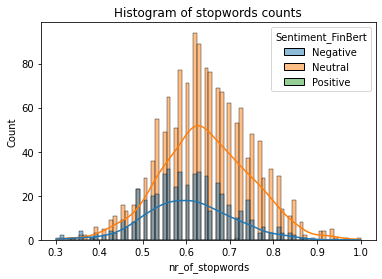

In [65]:
ax = sns.histplot(data=sentiment_data, x="nr_of_stopwords",bins=80, hue="Sentiment_FinBert",kde=True)
plt.title("Histogram of stopwords counts")

## Word Cloud 

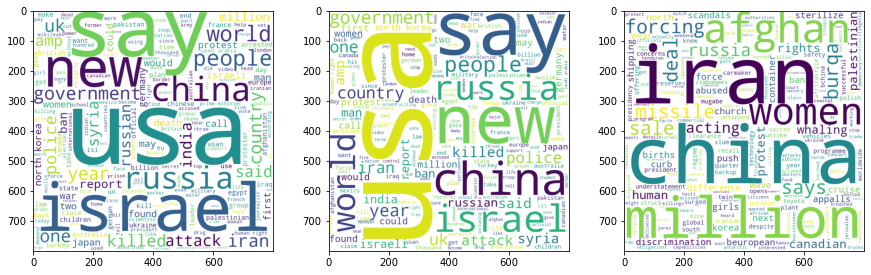

In [66]:
f, ax = plt.subplots(1,3, figsize=(15,15))
plt.subplot(3,3,1)
P = sentiment_data[sentiment_data.Sentiment_NTUSD == "Positive"].clean_news
text = " ".join(review for review in P)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'white', stopwords = stop_words).generate(text)
plt.imshow(wc)

plt.subplot(3,3,2)
Pt = sentiment_data[sentiment_data.Sentiment_Textblob == "Positive"].clean_news
textblob = " ".join(review for review in Pt)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'white', stopwords = stop_words).generate(textblob)
plt.imshow(wc)

plt.subplot(3,3,3)
Pf = sentiment_data[sentiment_data.Sentiment_FinBert == "Positive"].clean_news
FinBert = " ".join(review for review in Pf)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'white', stopwords = stop_words).generate(FinBert)
plt.imshow(wc)    

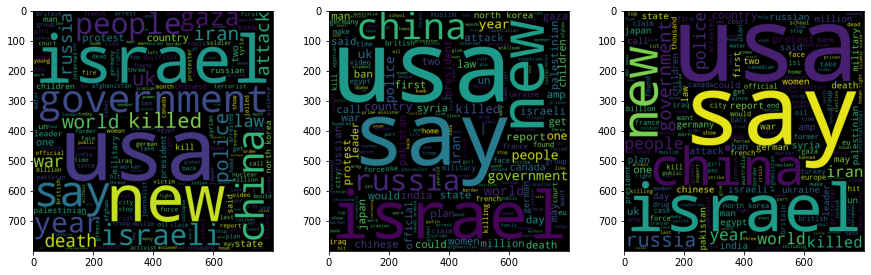

In [67]:
f, ax = plt.subplots(1,3, figsize=(15,15))
plt.subplot(3,3,1)
P = sentiment_data[sentiment_data.Sentiment_NTUSD == "Negative"].clean_news
text = " ".join(review for review in P)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'black', stopwords = stop_words).generate(text)
plt.imshow(wc)

plt.subplot(3,3,2)
Pt = sentiment_data[sentiment_data.Sentiment_Textblob == "Negative"].clean_news
textblob = " ".join(review for review in Pt)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'black', stopwords = stop_words).generate(textblob)
plt.imshow(wc)

plt.subplot(3,3,3)
Pf = sentiment_data[sentiment_data.Sentiment_FinBert == "Negative"].clean_news
FinBert = " ".join(review for review in Pf)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'black', stopwords = stop_words).generate(FinBert)
plt.imshow(wc)

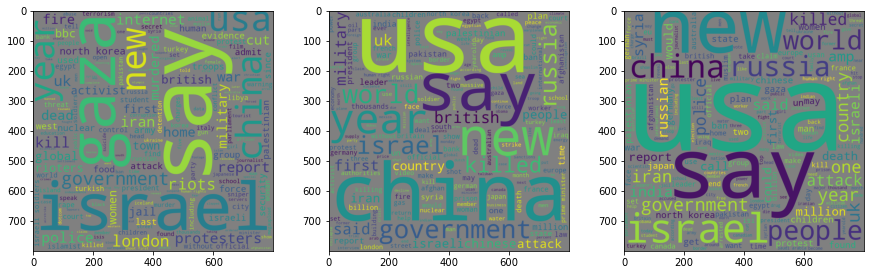

In [68]:
f, ax = plt.subplots(1,3, figsize=(15,15))
plt.subplot(3,3,1)
P = sentiment_data[sentiment_data.Sentiment_NTUSD == "Neutral"].clean_news
text = " ".join(review for review in P)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'gray', stopwords = stop_words).generate(text)
plt.imshow(wc)

plt.subplot(3,3,2)
Pt = sentiment_data[sentiment_data.Sentiment_Textblob == "Neutral"].clean_news
textblob = " ".join(review for review in Pt)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'gray', stopwords = stop_words).generate(textblob)
plt.imshow(wc)

plt.subplot(3,3,3)
Pf = sentiment_data[sentiment_data.Sentiment_FinBert == "Neutral"].clean_news
FinBert = " ".join(review for review in Pf)
wc = WordCloud(width=800, height=800, min_font_size=10, background_color = 'gray', stopwords = stop_words).generate(FinBert)
plt.imshow(wc)

## Word Frequency 

In [69]:
Top1 = pre_process_data['Top1'].apply(lambda x : str(x).split())

temp = Counter(item for sublist in Top1 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Top 1 Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',    128
1       'usa',    118
2     'world',    111
3    'govern',    104
4      'year',     89
5      'kill',     82
6     'peopl',     82
7       'ban',     81
8       'new',     79
9      'drug',     77


In [70]:
Top25 = pre_process_data['Top25'].apply(lambda x : str(x).split())

temp = Counter(item for sublist in Top25 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Top 25 Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',    136
1       'usa',    112
2      'kill',     89
3       'new',     82
4     'world',     75
5     'polic',     74
6   'countri',     74
7    'attack',     68
8      'year',     68
9    'govern',     67


In [71]:
Top1 = pre_process_data[['Top1','Label']]
Label1_Top1 =Top1[Top1.Label == 1].Top1.apply(lambda x : str(x).split())

temp = Counter(item for sublist in Label1_Top1 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Words Top 1 Label 1', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',     60
1      'kill',     52
2       'say',     51
3     'world',     50
4      'drug',     48
5       'ban',     46
6      'year',     43
7       'new',     43
8    'govern',     43
9       'use',     41


In [72]:
Top1 = pre_process_data[['Top1','Label']]
Label1_Top1 =Top1[Top1.Label == 0].Top1.apply(lambda x : str(x).split())

temp = Counter(item for sublist in Label1_Top1 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Words Top 1 Label 0', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',     77
1     'world',     61
2    'govern',     61
3       'usa',     58
4     'peopl',     48
5      'year',     46
6       'new',     36
7       'ban',     35
8     'polic',     32
9      'time',     31


In [73]:
Top25 = pre_process_data[['Top25','Label']]
Label1_Top25 =Top25[Top25.Label == 1].Top25.apply(lambda x : str(x).split())

temp = Counter(item for sublist in Label1_Top25 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Words Top 25 Label 1', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',     76
1       'usa',     65
2    'attack',     47
3      'kill',     47
4     'polic',     46
5   'countri',     43
6       'new',     41
7    'govern',     39
8     'state',     39
9   'protest',     37


In [74]:
Top25 = pre_process_data[['Top25','Label']]
Label0_Top25 =Top25[Top25.Label == 0].Top25.apply(lambda x : str(x).split())

temp = Counter(item for sublist in Label0_Top25 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Words Top 25 Label 0', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',     60
1       'usa',     47
2      'kill',     42
3       'new',     41
4     'world',     40
5      'year',     36
6   'countri',     31
7     'polic',     28
8    'govern',     28
9   'protest',     26


In [75]:
Label1 = sentiment_data[sentiment_data.Label == 1].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Label1 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Label 1 Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',   2368
1       'say',   1950
2      'kill',   1438
3      'year',   1366
4     'world',   1247
5       'new',   1237
6     'china',   1172
7    'govern',   1162
8    'israel',   1148
9     'polic',   1043


In [76]:
Label0 = sentiment_data[sentiment_data.Label == 0].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Label0 for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Label 0 Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',   2047
1       'say',   1673
2      'kill',   1212
3      'year',   1196
4     'world',   1154
5       'new',   1148
6    'govern',   1011
7     'china',    960
8    'israel',    949
9     'peopl',    922


In [77]:
Pos = sentiment_data[sentiment_data.Sentiment_NTUSD == "Positive"].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Pos for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Positive Sentiment Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',   4174
1       'say',   3417
2      'kill',   2414
3      'year',   2383
4     'world',   2291
5       'new',   2233
6    'govern',   2022
7     'china',   1994
8    'israel',   1909
9     'polic',   1809


In [78]:
Pos = sentiment_data[sentiment_data.Sentiment_Textblob == "Positive"].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Pos for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Positive Sentiment Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',   2922
1       'say',   2539
2      'year',   1767
3      'kill',   1732
4       'new',   1720
5     'world',   1660
6    'govern',   1497
7     'china',   1460
8    'israel',   1355
9     'polic',   1305


In [79]:
Pos = sentiment_data[sentiment_data.Sentiment_FinBert == "Neutral"].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Pos for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Positive Sentiment Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',   3343
1       'say',   2667
2      'year',   1938
3      'kill',   1930
4       'new',   1860
5     'world',   1844
6    'govern',   1622
7     'china',   1581
8    'israel',   1573
9     'peopl',   1418


In [80]:
Neg = sentiment_data[sentiment_data.Sentiment_NTUSD == "Negative"].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Neg for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Negative Sentiment Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'usa',    232
1      'kill',    227
2       'say',    191
3    'israel',    178
4      'year',    170
5      'isra',    146
6       'new',    146
7    'govern',    142
8     'peopl',    135
9     'china',    129


In [81]:
Neu = sentiment_data[sentiment_data.Sentiment_NTUSD == "Neutral"].news_stemmed.apply(lambda x : str(x).split())
temp = Counter(item for sublist in Neu for item in sublist)
top = pd.DataFrame(temp.most_common(10))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common Neutral Sentiment Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

  Common_words  count
0       'say',     15
1    'israel',     10
2   'protest',     10
3      'gaza',     10
4       'usa',      9
5      'kill',      9
6      'year',      9
7     'china',      9
8    'govern',      9
9    'report',      9


## Correlation between compounds Sentiment Analysis

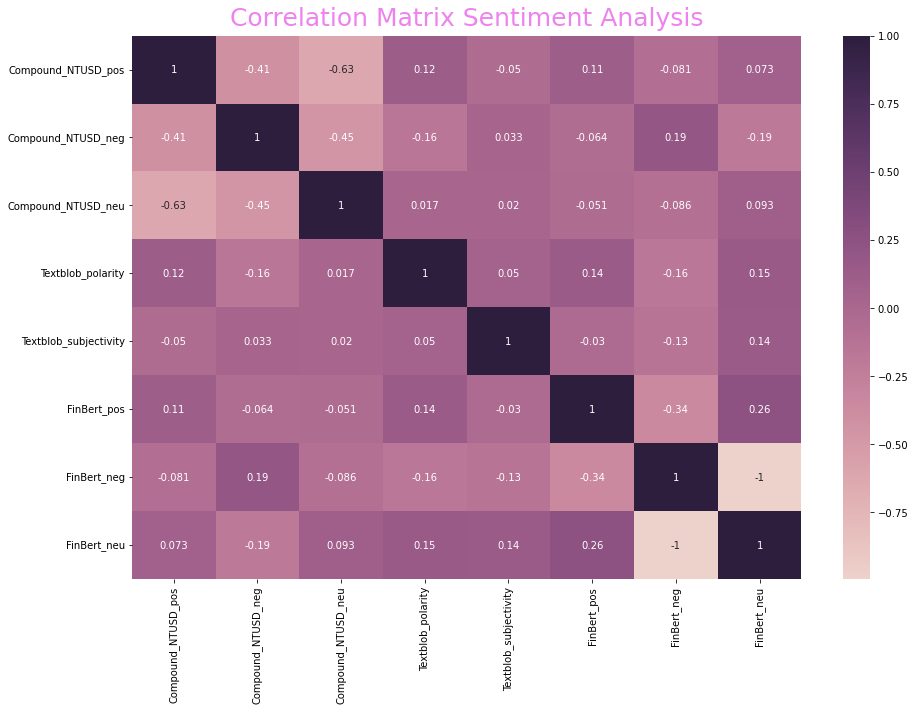

In [82]:
cm = sentiment_data[['Compound_NTUSD_pos','Compound_NTUSD_neg','Compound_NTUSD_neu','Textblob_polarity',
                    'Textblob_subjectivity','FinBert_pos','FinBert_neg','FinBert_neu']].copy()
plt.figure(figsize = (15,10))
sns.heatmap(cm.corr(), annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Correlation Matrix Sentiment Analysis", fontsize = 25, color = 'violet', pad = 10, loc = 'center')
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

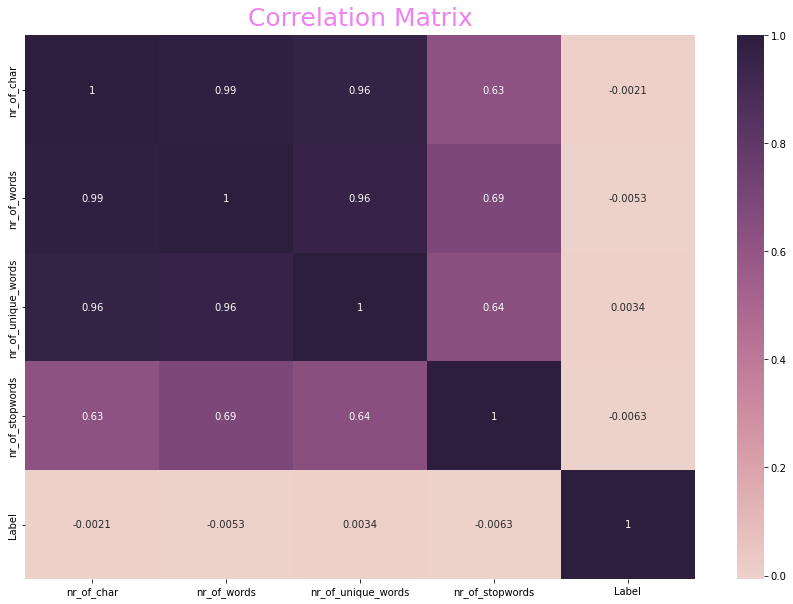

In [87]:
# Merge the two datasets based on date
cm = sentiment_data[['nr_of_char','nr_of_words', 'nr_of_unique_words', 'nr_of_stopwords','Label']].copy()
#merged_df = pd.merge(sentiment_data, stock_data, on="Date")
plt.figure(figsize = (15,10))
sns.heatmap(cm.corr(), annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Correlation Matrix", fontsize = 25, color = 'violet', pad = 10, loc = 'center')

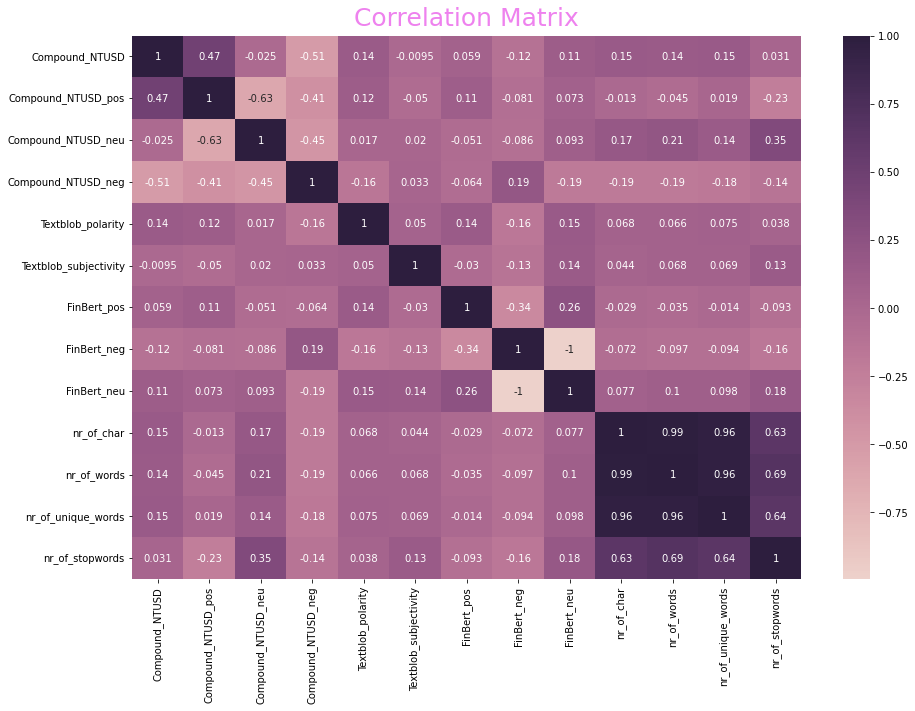

In [85]:
cm = sentiment_data[['Compound_NTUSD', 'Compound_NTUSD_pos', 'Compound_NTUSD_neu',
       'Compound_NTUSD_neg', 'Sentiment_NTUSD', 'Textblob_polarity',
       'Textblob_subjectivity', 'Sentiment_Textblob', 'FinBert_pos',
       'FinBert_neg', 'FinBert_neu', 'Sentiment_FinBert', 'nr_of_char',
       'nr_of_words', 'nr_of_unique_words', 'nr_of_stopwords']].copy()
plt.figure(figsize = (15,10))
sns.heatmap(cm.corr(), annot = True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Correlation Matrix", fontsize = 25, color = 'violet', pad = 10, loc = 'center')
plt.show()